In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob
from moviepy.editor import VideoFileClip


In [2]:
########## THE FUNCTIONS ##########

def Calibrate_Cam (img, mtx, dist):
    dst = cv2.undistort (img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    sx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sx_abs = np.absolute( sx ) 
    scaled_sx = np.uint8(255*sx_abs/np.max(sx_abs))
    binary_output = np.zeros_like(img) # Remove this line
    binary_output [ (scaled_sx>thresh[0]) & (scaled_sx<thresh[1]) ] = 1
    return binary_output

def hls_select_s(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0]) & (S<=thresh[1]) ]=1
    return binary_output

def hls_select_h(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    binary_output = np.zeros_like(h)
    binary_output[(h>thresh[0]) & (h<=thresh[1]) ]=1
    return binary_output

def Color_Gradient_Threshold(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    gradx = abs_sobel_thresh(gray, sobel_kernel=7, orient='x',thresh=(50, 255))
    S_binary = hls_select_s(img, thresh=(90, 255))
    H_binary = hls_select_h(img, thresh=(90, 255))
    binary [ (gradx == 1)  | ((S_binary == 1)&(H_binary==0)) ] =1 
    return binary

def Bird_Eye (img):
    src=np.float32([ [575, 463], [280, 660], [1000,660], [705,463] ]) #source points
    dst=np.float32([ [290, 5], [290, 700], [990,700], [990,5]])       #distination points 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img,M , img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv
    
def find_lane_pixels(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    ### Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))
    
    ### Find the peak of the left and right halves of the histogram
    ### These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        
        ###the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current-margin 
        win_xright_high = rightx_current+margin
        
        ### Draw the sliding windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = (nonzerox<warped.shape[1]/2) & (nonzerox<win_xleft_high) & (nonzerox>=win_xleft_low) & (nonzeroy<win_y_high) & (nonzeroy>=win_y_low)
        good_right_inds =(nonzerox>warped.shape[1]/2) & (nonzerox<win_xright_high) & (nonzerox>=win_xright_low) & (nonzeroy<win_y_high) & (nonzeroy>=win_y_low)
        good_left_inds = good_left_inds.nonzero()[0]
        good_right_inds = good_right_inds.nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### else, try to be parallel to the other line
        
        if np.sum(good_left_inds) > minpix:
            leftx_current = int( np.mean( nonzero[1][good_left_inds] ) )
        elif np.sum(good_right_inds) > minpix:
            leftx_current += (int(np.mean( nonzero[1][good_right_inds]) )-rightx_current)
            
        if np.sum(good_right_inds) > minpix:
            rightx_current = int(np.mean( nonzero[1][good_right_inds]) )
        elif np.sum(good_left_inds) > minpix:
            rightx_current += (int( np.mean( nonzero[1][good_left_inds] ) )-leftx_current)
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img



def Detect_Lanes(warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

  

    try:
        ### Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    warp_zero = np.zeros_like(out_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the area between lanes onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 0.9, warp_zero, 0.6, 0) #adding the green area with alpha 0.6 to the image
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return result, left_fitx, right_fitx, ploty


def unwarp(img, Lanes, Minv):
    newwarp = cv2.warpPerspective(Lanes, Minv, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.8, 0)
    return result


ym_per_pix = 3/100 # meters per pixel in y dimension (WRT the dashed line length)
xm_per_pix = 3.7/700 # meters per pixel in x dimension (WRT the distance between the lanes)

def measure_curvature_real(left_fitx, right_fitx, ploty):
    
    #Fit polynomial to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### The calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    return left_curverad, right_curverad

  

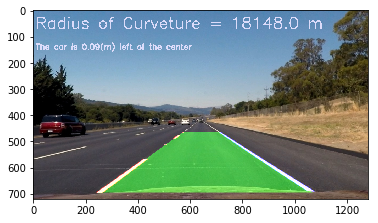

In [12]:

nx, ny = 9,6 #number of x and y corners for the chessboards we have

objpoints =[] #3d points for the real world points
imgpoints =[] #2d points for the image points

##To Create the object points for one iteration
objp = np.zeros((nx*ny, 3), np.float32) 
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


#to read all the calibration images
images = glob.glob("camera_cal/calibration*.jpg")
#To calculate all objpoints and all imgpoints
for image in images:
    ret, corners = cv2.findChessboardCorners(cv2.imread(image), (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

#To calibrate the camera 
imgg=cv2.imread(images[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgg.shape[1::-1], None, None)


## Reading all test images and processing them
images=glob.glob("test_images/straight_lines2.jpg")
for image in images:
        
    img = mpimg.imread(image) 
    
    ###### image distortion correction
    undestorted = Calibrate_Cam(img, mtx, dist)

    ###### Color and Gradient Threshold
    binary = Color_Gradient_Threshold(undestorted)


    ###### Prespective Transform (Warp image)
    warped, Minv = Bird_Eye(binary)
    warped_color, Minv = Bird_Eye(undestorted)

    
    ###### Detect Line Lanes
    lanes, left_fitx, right_fitx, ploty = Detect_Lanes(warped)

    final = unwarp(undestorted, lanes, Minv)
    
    
    ###### Determine lane curveture
    left_cur, right_cur = measure_curvature_real(left_fitx, right_fitx, ploty)

    #Find the position of the car
    lanes_mid = (left_fitx[(ploty==img.shape[0]-1)] + right_fitx[(ploty==img.shape[0]-1)]) /2
    img_mid = img.shape[1]/2
    diff = (np.absolute(lanes_mid-img_mid))*xm_per_pix

    position = 'The car is ' + ("%.2f" % diff) + '(m) '
    if lanes_mid <= img_mid:
        position += 'right of the center'
    else :
        position += 'left of the center'
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (220, 220, 250)
    cur = str((left_cur + right_cur)//2)
    
    ##Writing Text on the images
    cv2.putText(final, "Radius of Curveture = "+cur + " m", (10,70), font, 2, fontColor, 3)
    cv2.putText(final, position, (10,150), font, 1, fontColor, 3)
    
    
    
    #cv2.imwrite('binary.jpg', binary*255)
    cv2.imwrite('final.jpg', cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
    #cv2.imwrite('lanes.png', lanes)
    #cv2.imwrite('final.png', cv2.cvtColor(final, cv2.COLOR_RGB2BGR))


    
    plt.imshow(final, cmap='gray')
    plt.show()

    
    
 

In [4]:
def process_image(img):
         
    ###### image distortion correction    
    undestorted = Calibrate_Cam(img, mtx, dist)
    
    ###### Color and Gradient Threshold
    binary = Color_Gradient_Threshold(undestorted)
    
    ###### Prespective Transform (Warp image)
    warped, Minv = Bird_Eye(binary)
    
    ###### Detect Line Lanes
    lanes, left_fitx, right_fitx, ploty = Detect_Lanes(warped)
    final = unwarp(undestorted, lanes, Minv)
    
    ###### Determine lane curveture
    left_cur, right_cur = measure_curvature_real(left_fitx, right_fitx, ploty)
    
    #Find the position of the car
    lanes_mid = (left_fitx[(ploty==img.shape[0]-1)] + right_fitx[(ploty==img.shape[0]-1)]) /2
    img_mid = img.shape[1]/2
    diff = (np.absolute(lanes_mid-img_mid))*xm_per_pix

    position = 'The car is ' + ("%.2f" % diff) + '(m) '
    if lanes_mid <= img_mid:
        position += 'right of the center'
    else :
        position += 'left of the center'
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (220, 220, 250)
    cur = str((left_cur + right_cur)//2)
    
    ##Writing Text on the images
    cv2.putText(final, "Radius of Curveture = "+cur + " m", (10,70), font, 2, fontColor, 3)
    cv2.putText(final, position, (10,150), font, 1, fontColor, 3)
    
    return final

In [5]:
white_output = 'test_videos_output/cur_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/cur_video.mp4
[MoviePy] Writing video test_videos_output/cur_video.mp4


100%|█████████▉| 1260/1261 [05:10<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/cur_video.mp4 

Wall time: 5min 11s
